# Import Packages

In [1]:
import sys,os,pdb,glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.io import fits
from astropy.table import Table, join, MaskedColumn
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astroquery.vizier import Vizier
import warnings
from astropy.logger import AstropyWarning
warnings.filterwarnings('ignore', category=AstropyWarning)

# Define Functions

In [2]:
def get_data(catalog, join_key='Name', join_type='inner'):

    """
    PURPOSE:    Get data from literature with Vizier

    INPUT:      catalog = ctalog name on Vizier (str)
                join_key = column header to join tables, if multiple (str; optional)
                join_type = way to join tables, if multiple (str; optional)

    OUTPUT:     t = data table (AstroPy Table)

    """

    ### GET FULL CATALOG (ALL COLUMNS, ALL ROWS)
    viz = Vizier(catalog=catalog, columns=['**'])
    viz.ROW_LIMIT = -1
    tv = viz.get_catalogs(catalog)

    ### IF MULTIPLE TABLES, JOIN THEN
    for i, val in enumerate(tv.keys()):
        if i == 0:
            t = tv[val]
        else:
            tt = tv[val]
            if join_key in tt.columns:
                t = join(t, tt, join_type=join_type, keys=join_key)

    return t


def get_grid(nb_row, nb_col):

    """
    PURPOSE:    Get grid positions for plot

    INPUT:      nb_row = number of rows in grid (float)
                nb_col = number of columns in grid (float)

    OUTPUT:     Plot grid info useful for plotting

    """

    nb_plots = nb_col * nb_row
    grid_size = (nb_row, nb_col)

    grid_pos = []
    for j in range(nb_row):
        for i in range(nb_col):
            temp = [j, i]
            grid_pos.append(temp)

    return nb_plots, grid_size, grid_pos


def readfits(file):

    """
    PURPOSE:    Read in FITS file and header info

    INPUT:      file = path to FITS file (str)

    OUTPUT:     data = image data (2x2 float arr)
                xcen, ycen = image center coordinates in pixels (float)
                xpix, ypix = image pixel width in deg/pix units (float)
                xcen_ra, xcen_de = image center coordinates in deg units (float)

    """

    hdulist = fits.open(file)
    data = hdulist[0].data[0, 0, :, :]
    head = hdulist[0].header
    hdulist.close()

    xcen = head['CRPIX1']
    ycen = head['CRPIX2']
    xpix = head['CDELT1']
    ypix = head['CDELT2']
    xcen_ra = head['CRVAL1']
    xcen_de = head['CRVAL2']

    return(data, xcen, ycen, xpix, ypix, xcen_ra, xcen_de)


def add_beam(bmj, bmn, bpa, sx, sy, bcol, ax):

    """
    PURPOSE:    Add beam to image

    INPUT:      bmj, bmn = beam major & minor axis in arcsec (float)
                bpa = beam position angle in degrees (float)
                sx, sy = location to plot beam (float)
                bcol = color of beam for plotting (str)
                ax = ax to plot beam (matplotlib ax)

    OUTPUT:     ax, but now with beam plotted (matplotlib ax) 

    """

    epa = 90. + bpa
    ell = Ellipse(xy=(sx, sy), width=bmj, height=bmn, angle=epa, edgecolor=bcol,
                  fc='None', linewidth=1.5, linestyle='solid')
    ax.add_patch(ell)

    return ax


def scale_sqrt(img_input, scale_min=None, scale_max=None):
	    
    """
    PURPOSE:    Scale image to look better in plotting

    INPUT:      img_input = image to scale (float arr)
                scale_min = lower bound of scaling (arr)
                scale_max = upper bound of scaling (arr)

    OUTPUT:     img = scaled image (float arr)

    """

    img = np.array(img_input, copy=True)
	
    if scale_min == None:
        scale_min = img.min()
    if scale_max == None:
        scale_max = img.max()

    img = img.clip(min=scale_min, max=scale_max)
    img = img - scale_min
    indices = np.where(img < 0)
    img[indices] = 0.0
    img = np.sqrt(img)
    img = img / np.sqrt(scale_max - scale_min)

    return img


def crop_img(target, ra, dec, line, mult, w_arcsec):

    """
    PURPOSE:    Crop image centered on scource

    INPUT:      target = target name used in image file name (str)
                ra, dec = RA, DE of object 1 in '[hr/deg] [min] [sec]' format (str)
                line = line suffix used in image file name (str)
                mult = multiplication factor to correct image units (float)
                w_arcsec = width of cropped image in arcseconds (float)

    OUTPUT:     img = cropped & centered image (float arr)
                rms = rms of uncropped image (float)

    """

    ### GET COORDINATES OF OBJECT FROM PAPER TABLE
    de_obj = str(dec.split(' ')[0][0]) + str(dec.split(' ')[0][1:]) + 'd' + str(dec.split(' ')[1]) + 'm' + str(dec.split(' ')[2]) + 's'
    ra_obj = str(ra.split(' ')[0]) + 'h' + str(ra.split(' ')[1]) + 'm' + str(ra.split(' ')[2]) + 's'
    c_obj = SkyCoord(ra_obj, de_obj, frame='icrs')

    ### GET CONTINUUM IMAGE FILE NAME
    file_img = '../data/FITS/S_' + target + '_' + line + '.fits'
    if os.path.isfile(file_img) is False:
        print('missing ' + line + ' FITS file for ' + target)
        pdb.set_trace()
        
    ### LOAD IMAGE AND GET CENTER COORDINATES
    img, xcen_img, ycen_img, xpix_img, ypix_img, xcen_ra, ycen_de = readfits(file_img)
    rms = np.std(img) * mult
    c_img = SkyCoord(xcen_ra, ycen_de, frame='icrs', unit='deg')
    
    ### CENTER IMAGE ON OBJECT LOCATION 
    dra, ddec = c_img.spherical_offsets_to(c_obj)
    width_pix = int(round(w_arcsec / (ypix_img * 3600.0)))
    xctr = xcen_img + dra.value / xpix_img
    yctr = ycen_img + ddec.value / ypix_img

    ### CROP IMAGE AND PUT INTO mJy UNITS
    img = mult * img[int(round(yctr - width_pix)):int(round(yctr + width_pix)),
                     int(round(xctr - width_pix)):int(round(xctr + width_pix))]
        
    return img, rms

# Code

Load in Sigma Orionis data

In [3]:
T = get_data("J/AJ/153/240")

Only keep gas detections and sort table by decreasing continuum flux

In [4]:
T = T[ (T['F12CO']/T['e_F12CO'] >= 3.0) & (T['l_F12CO'] != '<')]
T.sort('F1.33')
T.reverse()

Setup and create plot

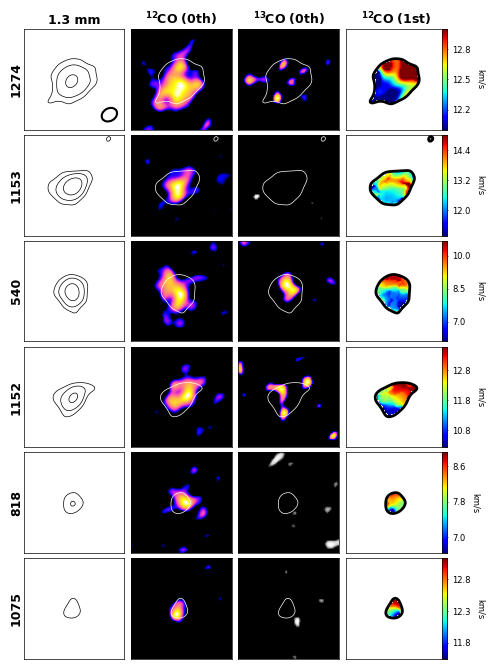

In [5]:
### SETUP PLOT
mpl.rc('xtick', labelsize=5)
mpl.rc('ytick', labelsize=5)
mpl.rc('xtick.major', size=1, pad=3, width=.5)
mpl.rc('ytick.major', size=1, pad=3, width=.5)
mpl.rc('axes', linewidth=0.5)
mpl.rc('lines', markersize=1)
fig = plt.figure(figsize = (5, 6.8))
w_as = 1.0
nb_col, nb_row = 4, len(T)
nb_plots, grid_size, grid_pos = get_grid(nb_row, nb_col)

### PLOT SOURCES
for i, val in enumerate(np.arange(nb_plots)):

    ### SET INDEX OF TARGET
    if (i == 0): 
         ind = 0
    if (i != 0) and (i % nb_col == 0): 
         ind = ind + 1
    Target = str(T['__HHM2007_'][ind])

    ### SET UP PLOT AXES
    ax = plt.subplot2grid(grid_size, grid_pos[i],aspect='equal')
    ax.axes.get_xaxis().set_visible(False)
    ax.tick_params(which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')

    ### PLOT CONTINUUM CONTOURS
    if (i % nb_col == 0):

        ### LABEL Y-AXIS WITH SOURCE NAME AND TOP AXIS WITH CONTINUUM IF FIRST ROW
        ax.set_ylabel(Target, fontsize=9, labelpad=0.5, fontweight="bold")
        ax.set_yticklabels([])
        ax.set_yticks([])

        ### GET CROPPED CONTINUUM IMAGE
        Img_Cont, RMS_Cont = crop_img(Target, T['RAJ2000'][ind], T['DEJ2000'][ind], 'cont', 1e3, w_as)

        ### PLOT CONTOUR AND ADD BEAM IF FIRST PANEL
        cs = ax.contour(Img_Cont, 2, levels=[4*T['rms'][ind], 10*T['rms'][ind], 25*T['rms'][ind]], colors='black', extent=[-w_as,w_as,-w_as,w_as],linewidths=0.5)
        if (i==0): 
             ax = add_beam(0.32, 0.25, -60.0, w_as * 0.7, -w_as * 0.7, 'black', ax)
             ax.set_title('1.3 mm', fontsize=9, fontweight="bold", y=0.97)

            
    ### PLOT 12CO ZERO-MOMENT MAP
    ### THE CASA/PYTHON SCRIPTS FOR MAKING THE MOMENT MAPS ARE IN '../casa'
    if (i % nb_col == 1):

        ### LABEL TOP AXIS WITH 12CO MOM0 IF FIRST ROW
        ax.axes.get_yaxis().set_visible(False)
        if i == 1: 
             ax.set_title(r'$\mathregular{^{12}\!\hspace{0.1}CO}$'+' (0th)',fontsize=9,fontweight="bold",y=0.97)

        ### GET CROPPED ZERO-MOMENT MAP 
        Img_mom0_12CO, RMS_mom0_12CO = crop_img(Target, T['RAJ2000'][ind], T['DEJ2000'][ind], '12CO_mom0', 1e3, w_as)

        ### SCALE IMAGE 
        Img_mom0_12CO = scale_sqrt(Img_mom0_12CO, scale_min=2.0*RMS_mom0_12CO, scale_max=Img_mom0_12CO.max()*1.5)

        # ### PLOT ZERO-MOMENT MAP AND ADD CONTINUUM CONTOUR
        ax.imshow(Img_mom0_12CO,extent=[-w_as,w_as,-w_as,w_as], origin='lower', cmap='gnuplot2', interpolation='bilinear')
        cs = ax.contour(Img_Cont, 2, levels=[4*T['rms'][ind]], colors='white', extent=[-w_as,w_as,-w_as,w_as], linewidths=0.5)

        
    ### PLOT 13CO ZERO-MOMENT MAP
    if (i % nb_col == 2):

        ### LABEL TOP AXIS WITH 13CO MOM0 IF FIRST ROW
        ax.axes.get_yaxis().set_visible(False)
        if i == 2: 
             ax.set_title(r'$\mathregular{^{13}\!\hspace{0.1}CO}$'+' (0th)',fontsize=9,fontweight="bold",y=0.97)

        ### GET CROPPED ZERO-MOMENT MAP 
        Img_mom0_13CO, RMS_mom0_13CO = crop_img(Target, T['RAJ2000'][ind], T['DEJ2000'][ind], '13CO_mom0', 1e3, w_as)

        ### SCALE IMAE AND GRAY-OUT NONDETECTIONS
        Img_mom0_13CO = scale_sqrt(Img_mom0_13CO, scale_min=2.0*RMS_mom0_13CO, scale_max=Img_mom0_13CO.max()*1.5)
        if T['l_F13CO'][ind] == '<':
             cmap = 'Greys_r'
        else: 
             cmap = 'gnuplot2'
        
        ### PLOT ZERO-MOMENT MAP WITH CONTINUUM CONTOUR    
        ax.imshow(Img_mom0_13CO, extent=[-w_as,w_as,-w_as,w_as], origin='lower', cmap=cmap, interpolation='bilinear')
        cs = ax.contour(Img_Cont, 2, levels=[4*T['rms'][ind]], colors='white', extent=[-w_as,w_as,-w_as,w_as], linewidths=0.5)


    ### PLOT 12CO FIRST-MOMENT MAP
    if (i % nb_col == 3):

    ### LABEL TOP AXIS WITH 12CO MOM1 IF FIRST ROW
        ax.axes.get_yaxis().set_visible(False)
        if i == 3: 
             ax.set_title(r'$\mathregular{^{12}\!\hspace{0.1}CO}$'+' (1st)',fontsize=9,fontweight="bold",y=0.97)

        ### GET CROPPED FIRST-MOMENT MAP 
        Img_mom1_12CO, RMS_mom1_12CO = crop_img(Target, T['RAJ2000'][ind], T['DEJ2000'][ind], '12CO_mom1', 1.0, w_as)

        ### MASK REGIONS BELOW SIGMA CUTOFF OF CONTINUUM IMAGE
        mask_out = np.where(Img_Cont < 4.0 * T['rms'][ind])
        Img_mom1_12CO[mask_out] = np.NaN

        ### FILL IN NAN REGIONS OF MOM-1 MAP WITH SYSTEMIC VELOCITY    
        mask_in  =  np.where( (Img_Cont >= 4.0 * T['rms'][ind]) & (np.isnan(Img_mom1_12CO) == True ) )
        Img_mom1_12CO[mask_in] = np.nanmean(Img_mom1_12CO)

        ### PLOT IMAGE FOR COLORBAR
        cb_image = ax.imshow(Img_mom1_12CO, extent=[-w_as,w_as,-w_as,w_as], origin='lower', cmap='jet', interpolation='bilinear')

        # ### PLOT CONTINUUM CONTOUR
        cs = ax.contour(Img_Cont, 2, levels=[4*T['rms'][ind]], colors='black', extent=[-w_as,w_as,-w_as,w_as], linewidths=2)

        ### FORCE COLORBAR TO BE SAME SIZE AS IMAGE AND PLACE INSIDE IMAGE SQUARE (-VE PADDING)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.05)

        ### ADD COLORBAR LABELS DEPENDING ON SOURCE
        if   Target == '1274': clabels = np.array([12.2,12.5,12.8])
        elif Target == '1153': clabels = np.array([12.0,13.2,14.4])
        elif Target == '540':  clabels = np.array([7.0,8.5,10.0])
        elif Target == '1152': clabels = np.array([10.8,11.8,12.8])
        elif Target == '818':  clabels = np.array([7.0,7.8,8.6])
        elif Target == '1075': clabels = np.array([11.8,12.3,12.8])
        cbar = plt.colorbar(cb_image, cax=cax)
        cbar.ax.tick_params(labelsize=6, labelright=True)
        cbar.ax.set_ylabel('km/s', fontsize=6, rotation=270, labelpad=10)
        cbar.set_ticks(clabels)
        cbar.set_ticklabels(clabels) 

fig.tight_layout()
fig.subplots_adjust(hspace=0.05, wspace=0.01)

Save Figure

In [6]:
fig.savefig('../output/figure_03.png', bbox_inches='tight', dpi=900)
plt.close('all')